In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame,Series
import json
import random
import requests
import datetime

#  从喜马拉雅的分类页面，获取分类列表，再从分类列表去获取每个专辑页面的url
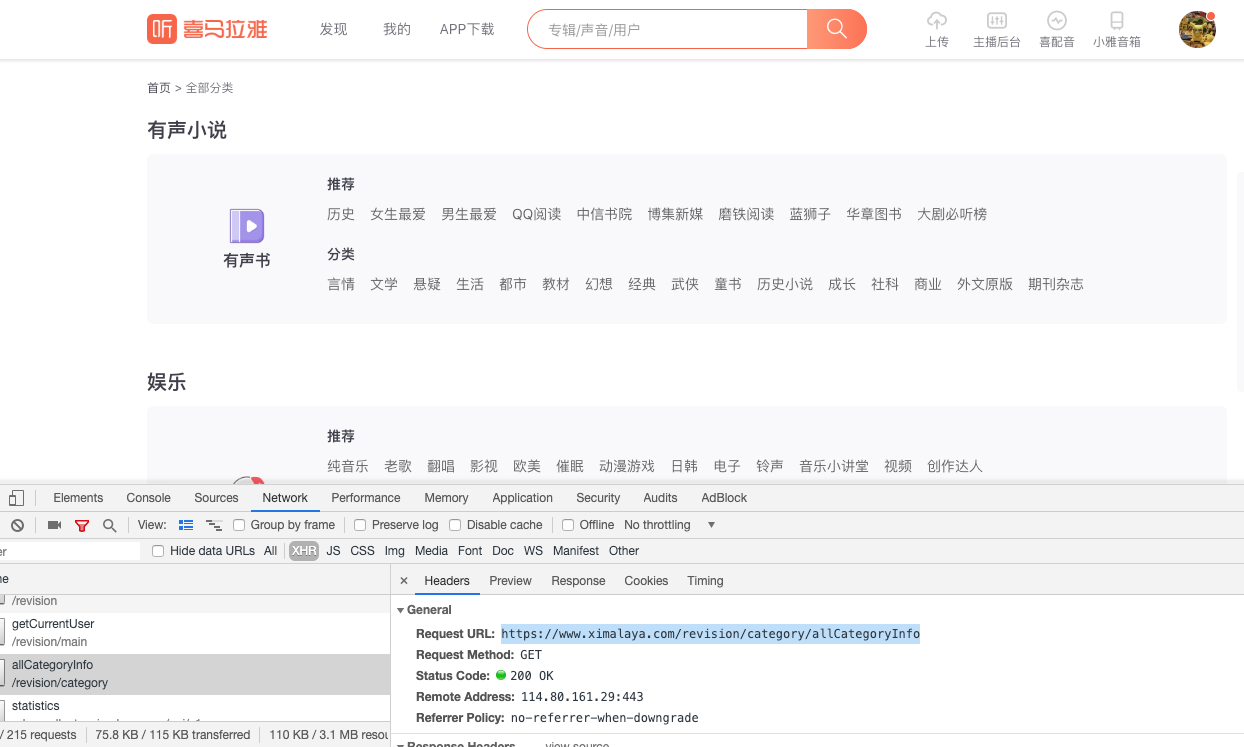

In [2]:
url_category = 'https://www.ximalaya.com/revision/category/allCategoryInfo'
Headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/75.0.3770.142 Safari/537.36'}
r = requests.get(url_category, headers = Headers)
json.loads(r.text)['data']
category = json.loads(r.text)['data']

#输出总目录页面的json数据
print(category)


[{'id': 1, 'name': '有声小说', 'position': 1, 'groupType': 1, 'displayStatus': 1, 'categories': [{'id': 3, 'categoryType': 0, 'displayStatus': 1, 'displayName': '有声书', 'link': '/youshengshu/', 'name': 'youshengshu', 'picPath': '//imagev2.xmcdn.com/group42/M07/B5/00/wKgJ9Fq16BSishjCAAAc2ts5ctw377.png', 'pinyin': 'youshengshu', 'position': 1, 'subcategories': [{'id': 3769, 'categoryId': 3, 'position': 1, 'metadataId': 226, 'metadataValue': '言情', 'code': 'yanqing', 'displayStatus': 1, 'link': '/youshengshu/yanqing/', 'displayValue': '言情', 'metas': [], 'isKeyword': False}, {'id': 3776, 'categoryId': 3, 'position': 1, 'metadataId': 225, 'metadataValue': '文学', 'code': 'wenxue', 'displayStatus': 1, 'link': '/youshengshu/wenxue/', 'displayValue': '文学', 'metas': [], 'isKeyword': False}, {'id': 3767, 'categoryId': 3, 'position': 2, 'metadataId': 226, 'metadataValue': '悬疑', 'code': 'xuanyi', 'displayStatus': 1, 'link': '/youshengshu/xuanyi/', 'displayValue': '悬疑', 'metas': [], 'isKeyword': False}, {'

In [3]:
#将这些数据清洗好存放到新的dict中：

target_list = {}

for i in range(len(category)):
    level_one = category[i]
    
    for j in range(len(level_one['categories'])):
        level_two = level_one['categories'][j]
        
        for k in range(len(level_two['subcategories'])):
            level_three = level_two['subcategories'][k]
            cate_list = {'level_one':level_one['name'], 
                         'level_two':level_two['displayName'],
                         'level_three':level_three['displayValue'],
                         'category':level_two['name'],
                         'subcategory':level_three['code']}
            print(cate_list)
            print('----第三级目录,link：  ', level_three['link'])  #that's what i wanted, to save it in targetlist
            target_list[level_three['link']] = cate_list


{'level_one': '有声小说', 'level_two': '有声书', 'level_three': '言情', 'category': 'youshengshu', 'subcategory': 'yanqing'}
----第三级目录,link：   /youshengshu/yanqing/
{'level_one': '有声小说', 'level_two': '有声书', 'level_three': '文学', 'category': 'youshengshu', 'subcategory': 'wenxue'}
----第三级目录,link：   /youshengshu/wenxue/
{'level_one': '有声小说', 'level_two': '有声书', 'level_three': '悬疑', 'category': 'youshengshu', 'subcategory': 'xuanyi'}
----第三级目录,link：   /youshengshu/xuanyi/
{'level_one': '有声小说', 'level_two': '有声书', 'level_three': '生活', 'category': 'youshengshu', 'subcategory': 'shenghuo'}
----第三级目录,link：   /youshengshu/shenghuo/
{'level_one': '有声小说', 'level_two': '有声书', 'level_three': '都市', 'category': 'youshengshu', 'subcategory': 'dushi'}
----第三级目录,link：   /youshengshu/dushi/
{'level_one': '有声小说', 'level_two': '有声书', 'level_three': '教材', 'category': 'youshengshu', 'subcategory': 'jiaocai'}
----第三级目录,link：   /youshengshu/jiaocai/
{'level_one': '有声小说', 'level_two': '有声书', 'level_three': '幻想', 'catego

In [4]:
len(target_list)

484

In [6]:
#开始爬取所有专辑的信息

detail_url = 'https://www.ximalaya.com/revision/category/queryCategoryPageAlbums?category=' 
data_total = DataFrame()

#通过总条数获取总页数
def get_total_page_num(total_count):
    if (total_count <= 30):
        return 1
    elif (total_count%30 == 0):
        return int(total_count/30)
    else:
        return int(total_count/30) + 1


#遍历一次总目录表
for i in target_list:
    cate_url = detail_url + target_list[i]['category'] + '&subcategory='+ target_list[i]['subcategory']+'&meta=&sort=2&page=' + str(1)+'&perPage=30'
    r=requests.get(cate_url, headers = Headers)
    json.loads(r.text)
    total_per_cate = get_total_page_num(json.loads(r.text)['data']['total'])
    
    data_sub_i = DataFrame()
    
    #遍历该目录下的子目录
    for j in range(1, total_per_cate + 1):
        final_url = detail_url + target_list[i]['category'] + '&subcategory='+ target_list[i]['subcategory']+'&meta=&sort=2&page=' + str(j)+'&perPage=30'
        r=requests.get(final_url, headers = Headers)  
        j_data = json.loads(r.text)
        data_sub_i = data_sub_i.append(DataFrame(j_data['data']['albums']))
        
        #获取这些信息：[category, sub_category]
        data_sub_i['category'] = target_list[i]['category']
        data_sub_i['subcategory'] = target_list[i]['subcategory']
        
        
    data_total = data_total.append(data_sub_i)
     
    print(target_list[i]['category'] + 
          '&subcategory=' + target_list[i]['subcategory'],
          datetime.datetime.now().strftime('%H:%M:%S'))
        

/Users/shenxibo/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


youshengshu&subcategory=yanqing 15:18:17
youshengshu&subcategory=wenxue 15:18:25
youshengshu&subcategory=xuanyi 15:18:34
youshengshu&subcategory=shenghuo 15:18:43
youshengshu&subcategory=dushi 15:18:52
youshengshu&subcategory=jiaocai 15:19:00
youshengshu&subcategory=huanxiang 15:19:08
youshengshu&subcategory=jingdian 15:19:18
youshengshu&subcategory=wuxia 15:19:29
youshengshu&subcategory=tongshu 15:19:41
youshengshu&subcategory=lishixiaoshuo 15:19:50
youshengshu&subcategory=lizhi 15:19:59
youshengshu&subcategory=sheke 15:20:08
youshengshu&subcategory=shangye 15:20:17
youshengshu&subcategory=yingwenyuanban 15:20:25
youshengshu&subcategory=qikanzazhi 15:20:27
youshengshu&subcategory=reci234 15:20:35
youshengshu&subcategory=reci346 15:20:43
youshengshu&subcategory=reci348 15:20:56
youshengshu&subcategory=reci22 15:21:06
youshengshu&subcategory=reci646 15:21:07
youshengshu&subcategory=reci26 15:21:10
youshengshu&subcategory=reci394 15:21:11
youshengshu&subcategory=reci419 15:21:12
yousheng

renwen&subcategory=shenhualunli 15:45:47
renwen&subcategory=zhuanji 15:45:57
renwen&subcategory=sheke 15:46:07
renwen&subcategory=shoucang 15:46:10
renwen&subcategory=ertong 15:46:18
renwen&subcategory=jingshen 15:46:31
renwen&subcategory=qinqi 15:46:31
renwen&subcategory=mingji 15:46:35
renwen&subcategory=zhuzi 15:46:37
renwen&subcategory=shijian 15:46:39
renwen&subcategory=jingdian 15:46:48
renwen&subcategory=tiandi 15:46:53
renwen&subcategory=reci431 15:47:02
renwen&subcategory=reci432 15:47:10
renwen&subcategory=reci427 15:47:19
renwen&subcategory=reci430 15:47:27
renwen&subcategory=reci433 15:47:30
renwen&subcategory=reci429 15:47:40
renwen&subcategory=reci428 15:47:49
renwen&subcategory=reci453 15:47:51
renwen&subcategory=reci440 15:48:01
renwen&subcategory=reci707 15:48:02
jiaoyu&subcategory=chuangye 15:48:12
jiaoyu&subcategory=falv 15:48:20
jiaoyu&subcategory=guanli 15:48:30
jiaoyu&subcategory=yingxiao 15:48:38
jiaoyu&subcategory=qiuzhi 15:48:45
jiaoyu&subcategory=goutongbiaoda

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [7]:
#由于运行到xiqu&subcategory=reci61时出错，需要给剩下的继续运行
#先保存好第一部分的DataFrame
data_total.head()

,albumId,anchorName,category,coverPath,isFinished,isPaid,link,playCount,subcategory,title,trackCount,uid,vipType
0,19383749,一刀苏苏,youshengshu,//imagev2.xmcdn.com/group50/M00/48/C5/wKgKmVvv...,1,False,/youshengshu/19383749/,540780885,yanqing,王的女人谁敢动｜爆笑古言穿越（免费双播精品）,714,30913215,0
1,7949508,风吹夜未央,youshengshu,//imagev2.xmcdn.com/group26/M03/60/11/wKgJWFkR...,0,False,/youshengshu/7949508/,446717926,yanqing,神秘男神，求休战。作者安缨,3440,58086964,0
2,3504297,CV马蹄酥,youshengshu,//imagev2.xmcdn.com/group18/M03/04/13/wKgJJVd7...,2,False,/youshengshu/3504297/,344714296,yanqing,相府嫡女,765,37418520,0
3,15398323,红颜醉送,youshengshu,//imagev2.xmcdn.com/group57/M0A/B4/FC/wKgLgVx-...,1,False,/youshengshu/15398323/,299917130,yanqing,总裁爹地很宠妻（都市言情文）,1402,104783015,0
4,16917799,璇儿是宝妈,youshengshu,//imagev2.xmcdn.com/group56/M08/AB/90/wKgLdlx-...,1,False,/youshengshu/16917799/,281154116,yanqing,抢婚成爱（高甜宠妻）,755,98966642,0


In [8]:
data_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 282483 entries, 0 to 9
Data columns (total 13 columns):
albumId        282483 non-null int64
anchorName     282483 non-null object
category       282483 non-null object
coverPath      282483 non-null object
isFinished     282483 non-null int64
isPaid         282483 non-null bool
link           282483 non-null object
playCount      282483 non-null int64
subcategory    282483 non-null object
title          282483 non-null object
trackCount     282483 non-null int64
uid            282483 non-null int64
vipType        282483 non-null int64
dtypes: bool(1), int64(6), object(6)
memory usage: 28.3+ MB


In [11]:
data_total.to_csv('ximalaya_0813_one.csv')

In [15]:
#截取出剩下未运行的目录

temp_list = target_list
del_list = []

for i in temp_list:
    del_list.append(i)
    if (i == '/xiqu/reci61/'):
        break
        
new_list = {}
for i in temp_list:
    if (i in del_list):
        continue
    else:
        new_list[i] = temp_list[i]
        
new_list

{'/xiqu/reci63/': {'level_one': '生活',
  'level_two': '戏曲',
  'level_three': '温婉越剧',
  'category': 'xiqu',
  'subcategory': 'reci63'},
 '/xiqu/reci62/': {'level_one': '生活',
  'level_two': '戏曲',
  'level_three': '明快黄梅',
  'category': 'xiqu',
  'subcategory': 'reci62'},
 '/xiqu/reci201/': {'level_one': '生活',
  'level_two': '戏曲',
  'level_three': '多彩沪剧',
  'category': 'xiqu',
  'subcategory': 'reci201'},
 '/xiqu/reci168/': {'level_one': '生活',
  'level_two': '戏曲',
  'level_three': '典雅昆曲',
  'category': 'xiqu',
  'subcategory': 'reci168'},
 '/xiqu/reci202/': {'level_one': '生活',
  'level_two': '戏曲',
  'level_three': '嬉笑怒骂二人转',
  'category': 'xiqu',
  'subcategory': 'reci202'},
 '/guangbojv/dushi/': {'level_one': '特色',
  'level_two': '广播剧',
  'level_three': '都市',
  'category': 'guangbojv',
  'subcategory': 'dushi'},
 '/guangbojv/xiaoyuan/': {'level_one': '特色',
  'level_two': '广播剧',
  'level_three': '校园',
  'category': 'guangbojv',
  'subcategory': 'xiaoyuan'},
 '/guangbojv/kehuan/': {'level_on

In [17]:
#第二次爬取

target_list = new_list
data_total_2 = DataFrame()

#遍历一次总目录表
for i in target_list:
    cate_url = detail_url + target_list[i]['category'] + '&subcategory='+ target_list[i]['subcategory']+'&meta=&sort=2&page=' + str(1)+'&perPage=30'
    r=requests.get(cate_url, headers = Headers)
    json.loads(r.text)
    total_per_cate = get_total_page_num(json.loads(r.text)['data']['total'])
    
    data_sub_i = DataFrame()
    
    #遍历该目录下的子目录
    for j in range(1, total_per_cate + 1):
        final_url = detail_url + target_list[i]['category'] + '&subcategory='+ target_list[i]['subcategory']+'&meta=&sort=2&page=' + str(j)+'&perPage=30'
        r=requests.get(final_url, headers = Headers)  
        j_data = json.loads(r.text)
        data_sub_i = data_sub_i.append(DataFrame(j_data['data']['albums']))
        
        #获取这些信息：[category, sub_category]
        data_sub_i['category'] = target_list[i]['category']
        data_sub_i['subcategory'] = target_list[i]['subcategory']
        
        
    data_total_2 = data_total_2.append(data_sub_i)
     
    print(target_list[i]['category'] + 
          '&subcategory=' + target_list[i]['subcategory'],
          datetime.datetime.now().strftime('%H:%M:%S'))
        

/Users/shenxibo/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


xiqu&subcategory=reci63 16:33:32
xiqu&subcategory=reci62 16:33:34
xiqu&subcategory=reci201 16:33:35
xiqu&subcategory=reci168 16:33:37
xiqu&subcategory=reci202 16:33:38
guangbojv&subcategory=dushi 16:33:50
guangbojv&subcategory=xiaoyuan 16:33:55
guangbojv&subcategory=kehuan 16:33:57
guangbojv&subcategory=qihuan 16:34:01
guangbojv&subcategory=jingsong 16:34:03
guangbojv&subcategory=xuanyi 16:34:06
guangbojv&subcategory=chuanyue 16:34:08
guangbojv&subcategory=gongting 16:34:11
guangbojv&subcategory=wuxia 16:34:15
guangbojv&subcategory=fuli 16:34:22
guangbojv&subcategory=reci546 16:34:30
guangbojv&subcategory=reci52 16:34:35
guangbojv&subcategory=reci54 16:34:44
guangbojv&subcategory=reci405 16:34:47
guangbojv&subcategory=reci339 16:34:47
diantai&subcategory=zonghetai 16:34:54
diantai&subcategory=yinyuetai 16:34:57
diantai&subcategory=wenyitai 16:35:03
diantai&subcategory=jingjitai 16:35:04
diantai&subcategory=xiaoyuantai 16:35:07
diantai&subcategory=jiaotongtai 16:35:08
diantai&subcategor

In [18]:
#爬取完毕，合并两个表

data_total = data_total.append(data_total_2)
data_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296190 entries, 0 to 8
Data columns (total 13 columns):
albumId        296190 non-null int64
anchorName     296190 non-null object
category       296190 non-null object
coverPath      296190 non-null object
isFinished     296190 non-null int64
isPaid         296190 non-null bool
link           296190 non-null object
playCount      296190 non-null int64
subcategory    296190 non-null object
title          296190 non-null object
trackCount     296190 non-null int64
uid            296190 non-null int64
vipType        296190 non-null int64
dtypes: bool(1), int64(6), object(6)
memory usage: 29.7+ MB


In [19]:
data_total.to_csv('ximalaya_0813_one.csv')